# Effect of Chunk Threshold

Here we demonstrate the effect (or lack thereof) of chunk threshold on the model's accuracy. We begin by setting up 10 models with varying chunk thresholds.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'


In [2]:
cd ~/Umila/numila

/Users/fred/Umila/numila


In [3]:
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import seaborn as sns

import main
import utils

/Users/fred/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [ ]:
# set up and train the models

corpus = main.syl_corpus()  # a generator
train_corpus = [next(corpus) for _ in range(1000)]
test_corpus = [next(corpus) for _ in range(100)]

models = OrderedDict()
for generalize in (0,0.1,0.2,0.3):
    params = {'DECAY_RATE': .0001,
              'FTP_PREFERENCE': 0.5,
              'GENERALIZE': generalize,
              'DIM': 1000}
    model, history = main.train(train_corpus,
                                track=None,
                                model_params=params,
                          )
    models[generalize] = model
    print('num nodes: ', len(model.graph.nodes))

# As a baseline, we use an untrained model.
import numila
untrained = numila.Numila()
models['baseline'] = untrained

## Testing the models

To test the model, we use a bag of words production task. The model receives a scrambled version of a novel utterance from the corpus and attempts to order it. See `Numila.speak()` for details.

We evaluate the models' performance using two metrics, as defined below.

In [ ]:
def exactly_equal_metric(lst1, lst2):
    """1 if the lists are the same, otherwise 0"""
    return 1 if lst1 == lst2 else 0

def common_neighbor_metric(lst1, lst2):
    """The percentage of adjacent pairs that are shared in two lists.
    Note that the metric is sensitive to the number of times a given
    pair occurs in each list.
    
    [1,2,3] [3,1,2] -> 0.5
    [1,2,3,1,2], [1,2,2,3,1] -> 0.75
    """
    pairs1 = Counter(utils.neighbors(lst1))
    pairs2 = Counter(utils.neighbors(lst2))
    num_shared = sum((pairs1 & pairs2).values())
    possible = sum(pairs1.values())
    return num_shared / possible

def evaluate_model(model, test_corpus, metric_func):
    """Evaluates a model's performance on a test corpus based on a given metric.
    
    metric_func takes in two lists and returns a number between 0 and 1
    quantifying the similarity between the two lists.

    Returns a list of metric scores comparing an adult utterance to
    the model's reconstruction of that utterance from a
    scrambeled "bag of words" version of the utterance.
    """
    # TODO: break down scores by list length
    scores = []
    for adult_utt in test_corpus:
        if len(adult_utt) > 1:  # can't evaluate a one word utterance
            parse = model.speak(adult_utt)
            model_utt = utils.flatten_parse(parse)
            scores.append(metric_func(model_utt, adult_utt))
    return scores

In [ ]:
# Evaluate each model using the two metrics.
common_neighbor = OrderedDict()
exactly_equal = OrderedDict()

for gen, model in models.items():
    scores = evaluate_model(model, test_corpus, common_neighbor_metric)
    common_neighbor[gen] = scores
    
    scores = evaluate_model(model, test_corpus, exactly_equal_metric)
    exactly_equal[gen] = scores

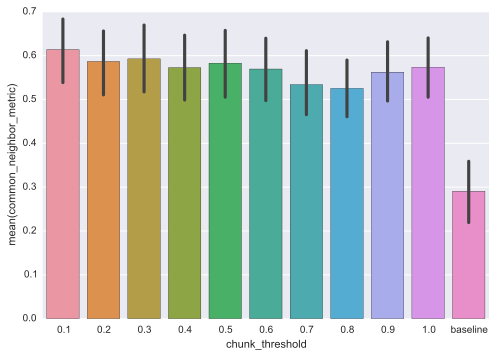

In [7]:
df = pd.DataFrame(common_neighbor)
mdf = pd.melt(df, var_name='generalize', value_name='common_neighbor_metric')
sns.barplot('generalize', 'common_neighbor_metric', data=mdf)

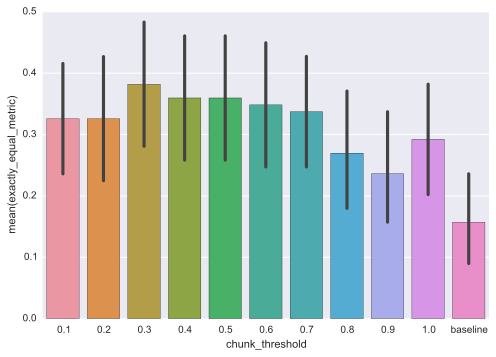

In [8]:
df = pd.DataFrame(exactly_equal)
mdf = pd.melt(df, var_name='chunk_threshold', value_name='exactly_equal_metric')
sns.barplot('chunk_threshold', 'exactly_equal_metric', data=mdf)

We find that chunking has no significant effect on the model's performance on the bag of words production task. This is true even when the threshold is set to 1.0, eliminating all chunks. On the bright side, the model does consistently perform above baseline.